<figure>
  <img style="float: left;" src="./figures/fair_1.png" width="200"/>
</figure>

# Lab 8 - Fairness of Predictive Models

In the last lab, we observed that models can exhibit unfairness towards minority groups. We measured Demographic Parity, Equal Opportunity, and Equalized Odds to quantify this unfairness. We also found that simply excluding the sensitive feature from the input features did not solve the problem, as it may be correlated with other features in the dataset. Finally, by excluding these correlated features, we were able to reduce the model's bias with a trade-off in accuracy.

Today, we will explore how to train a neural network to enhance model fairness using in-processing methods. More specifically, we will see how we can impose an additional regularization term in the model’s loss function that accounts for fairness.

### Group Fairness
In group fairness, different groups should be treated equally, ensuring fair outcomes across demographic groups.

# Correct the Unfair Classifier

In summary, there are three general methods to correct an unfair classifier:

1. **Pre-Processing**: Make changes to the data before training the model, e.g., removing correlated features.
2. **In-Processing**: Make changes to the model to correct fairness, e.g., adding additional loss terms to ensure fairness.
3. **Post-Processing**: Make changes after the model's output, e.g., adjusting classification thresholds.

For an overview of different methods and fairness criteria, we refer you to the following interesting survey: [https://arxiv.org/pdf/2001.09784.pdf](https://arxiv.org/pdf/2001.09784.pdf).

<div>
<img style="float: left;" src="./figures/corect_unfairness.png" width="400"/>
</div>

In [65]:
!pip install torch==2.1.0

You should consider upgrading via the '/Users/andreasathanasopoulos/Phd/projects/bayesian_fairness/envs/bayesian-fairness/bin/python3.9 -m pip install --upgrade pip' command.


In [66]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# A1. Load Dataset

https://archive.ics.uci.edu/ml/datasets/adult

In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [68]:
from collections import OrderedDict

data_types = OrderedDict([
    ("age", "int"),
    ("workclass", "category"),
    ("final_weight", "int"),  # originally it was called fnlwgt
    ("education", "category"),
    ("education_num", "int"),
    ("marital_status", "category"),
    ("occupation", "category"),
    ("relationship", "category"),
    ("race", "category"),
    ("sex", "category"),
    ("capital_gain", "float"),  # required because of NaN values
    ("capital_loss", "int"),
    ("hours_per_week", "int"),
    ("native_country", "category"),
    ("income_class", "category"),
])
target_column = "income_class"

In [69]:
def read_dataset(path):
    return pd.read_csv(
        path,
        names=data_types,
        index_col=None,

        comment='|',  # test dataset has comment in it
        skipinitialspace=True,  # Skip spaces after delimiter
        na_values={
            'capital_gain': 99999,
            'workclass': '?',
            'native_country': '?',
            'occupation': '?',
        },
        dtype=data_types,
    )

def clean_dataset(data):
    # Test dataset has dot at the end, we remove it in order
    # to unify names between training and test datasets.
    data['income_class'] = data.income_class.str.rstrip('.').astype('category')
    
    # Remove final weight column since there is no use
    # for it during the classification.
    data = data.drop('final_weight', axis=1)
    
    # Duplicates might create biases during the analysis and
    # during prediction stage they might give over-optimistic
    # (or pessimistic) results.
    data = data.drop_duplicates()
    
    # Binary target variable (>50K == 1 and <=50K == 0)
    data[target_column] = (data[target_column] == '>50K').astype(int)
    
    # Categorical dataset
    categorical_features = data.select_dtypes('category').columns
    data[categorical_features] = data.select_dtypes('category').apply(lambda x: x.cat.codes)
    return data

### load & clean dataset

In [70]:
# get and clean train dataset
TRAIN_DATA_FILE = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
train_data = clean_dataset(read_dataset(TRAIN_DATA_FILE))
train_data = train_data.dropna()
print("Train dataset shape:", train_data.shape)

# get and clean test dataset
TEST_DATA_FILE = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'
test_data = clean_dataset(read_dataset(TEST_DATA_FILE))
test_data = test_data.dropna()
print("Test dataset shape:", test_data.shape)

Train dataset shape: (28938, 14)
Test dataset shape: (15175, 14)


In [71]:
target_column = "income_class"
sensitive_feature = "sex"
features = train_data.columns.difference([target_column, sensitive_feature]).tolist()

In [72]:
train_data.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_class
0,39,6,9,13,4,0,1,4,1,2174.0,0,40,38,0
1,50,5,9,13,2,3,0,4,1,0.0,0,13,38,0
2,38,3,11,9,0,5,1,4,1,0.0,0,40,38,0
3,53,3,1,7,2,5,0,2,1,0.0,0,40,38,0
4,28,3,9,13,2,9,5,2,0,0.0,0,40,4,0


### Data analysis

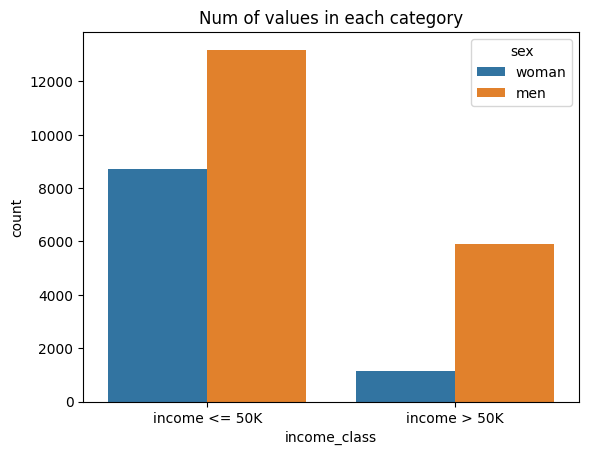

In [73]:
plt.figure()
fig = sns.countplot(data=train_data[["income_class","sex"]],
                    x="income_class",
                    hue="sex")
fig.set_xticklabels(['income <= 50K','income > 50K'])
plt.legend(title='sex', labels=['woman', 'men'])
plt.title("Num of values in each category")
plt.show()
plt.close()

# A2. Prepare Data


### A. Get train val test set

In [81]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_data[features+[sensitive_feature]], train_data[[target_column]], test_size=0.1, random_state=1234)
X_test, y_test = test_data[features], test_data[[target_column]]

### B. Data Scalling

In [75]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[features]),index=X_train.index,columns = features)
X_val_scaled = pd.DataFrame(scaler.transform(X_val[features]),index=X_val.index,columns = features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[features]),index=X_test.index ,columns = features) # note that here we just use the transform method!

### C. Get torch itterator
To efficiently iterate over the dataset during training, we will use PyTorch’s  `DataLoader` that consumes a `TensorDataset` object.

In [76]:
# covert data into tensors
train_x_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float)
train_y_tensor = torch.tensor(y_train[[target_column]].values, dtype=torch.float)

# use the dataset class wrapper for tensors
train_tensor_dataset = torch.utils.data.TensorDataset(train_x_tensor, train_y_tensor)# there are more coplex dataset
                                                                                     # i.e images or text data

# pass the dataset class into Dataloader to batch and shuffle your data
train_dataloader = torch.utils.data.DataLoader(train_tensor_dataset,
                                               batch_size=32,
                                               shuffle=True)

In [77]:
# covert data into tensors
val_x_tensor = torch.tensor(X_val_scaled.values, dtype=torch.float)
val_y_tensor = torch.tensor(y_val[[target_column]].values, dtype=torch.float)

# use the dataset class wrapper for tensors
val_tensor_dataset = torch.utils.data.TensorDataset(val_x_tensor, val_y_tensor)

In [78]:
# covert data into tensors
test_x_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float)
test_y_tensor = torch.tensor(y_test[[target_column]].values, dtype=torch.float)

# use the dataset class wrapper for tensors
test_tensor_dataset = torch.utils.data.TensorDataset(test_x_tensor, test_y_tensor)

The dataset is quite imbalance between a gender, so we expect our model to be unfair.
The source of the bias is coming from our societal bias.

# A3. Define  Model

In [82]:
class NeuralNetwork(torch.nn.Module):
    """
    Simple two layer neural network for regression
    """
    def __init__(self, num_input_features):
        super().__init__()
        
        # layer 1
        layer_1_units = 20
        self.layer_1 = torch.nn.Linear(in_features=num_input_features,
                                       out_features=layer_1_units)
        self.activation_1 = torch.nn.ReLU()
        
        # layer  2
        layer_2_units = 10
        self.layer_2 = torch.nn.Linear(in_features=layer_1_units,
                                       out_features=layer_2_units)
        self.activation_2 = torch.nn.ReLU()
        
        # layer output layer
        self.out_layer = torch.nn.Linear(in_features=layer_2_units,
                                         out_features=1)
        self.out_activation= torch.nn.Sigmoid()

    def forward(self, x):
        x_1 = self.activation_1( self.layer_1( x ) )
        x_2 = self.activation_2( self.layer_2( x_1 ) )
        output = self.out_activation(self.out_layer(x_2))
        return output

In [83]:
from sklearn.metrics import accuracy_score
model = NeuralNetwork(num_input_features=12)

### A4. Define training prossec

In [84]:
def training_step(model, input_data, optimizer, loss_fn, lamda):
    # reset gradients of the optimizer
    optimizer.zero_grad()
    
    # unfold data
    x_batch, y_batch = input_data
    
    # get predictions
    y_pred_propa = model.forward(x_batch)
    
    # calculate loss
    loss = loss_fn(y_pred_propa, y_batch)

    # compute gradients 
    loss.backward()
    
    # optimise network
    optimizer.step()
    
    # compute metrics for monitoring
    with torch.no_grad(): 
        y_pred = (y_pred_propa>0.5) * 1
        train_acc = torch.sum(y_pred == y_batch) / y_batch.shape[0]

    return loss.data.numpy(), train_acc.data.numpy()

In [85]:
def evaluation_step(model, input_data, loss_fn):
    # when we use torch.no_grad pytorch didnt store information
    # that is required to calculate gradients so is fasterr 
    with torch.no_grad(): 
        x_batch, y_batch = val_tensor_dataset.tensors
        y_pred_proba = model(x_batch)
        loss = loss_fn(y_pred_proba, y_batch)

        # compute metrics
        y_pred = (y_pred_proba>0.5) * 1
        acc = torch.sum(y_pred == y_batch) / y_batch.shape[0]
    return loss.data.numpy(), acc.data.numpy()

In [87]:
# -------------------- Train  Loop----------------------------
def train_loop(train_dataloaders, val_tensor_dataset, patient, epochs, model, optimizer, loss_fn, lamba, steps_per_epoch = 1000):
    best_loss = np.inf
    consecutive_epoch = 0
    best_epoch = 0

    train_history = []
    val_history = []
    for epoch in range(epochs): # iterate over epoch    
        
        # -------------------- Training on each epoch ----------------------------
        accumulated_loss = 0 # monitor loss during training
        accumulated_accuracy = 0 # monitor  accuracy during training
        accuracy_list = []
        for step in range(steps_per_epoch):
            batch_data = next(iter(train_dataloader))
            loss, accuracy = training_step(model,batch_data,optimizer,loss_fn,lamba) # train model using a single batch
            accuracy_list += [accuracy]
            accumulated_loss = (step * accumulated_loss + loss)/(step+1)
            accumulated_accuracy =  (step * accumulated_accuracy + accuracy)/(step+1)

        train_history += [{"loss":accumulated_loss, "accuracy":accumulated_accuracy, "epoch": epoch, "set":"train"}]

        # -------------------- Monitor Error Validation set ----------------------------
        val_loss, val_accuracy = evaluation_step(model, val_tensor_dataset, loss_fn)
        val_history += [{"loss":val_loss, "accuracy":val_accuracy, "epoch": epoch, "set":"val"}]
        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs}:  loss:{accumulated_loss:.3f}, accuracy-:{accumulated_accuracy:.3f}, val_loss:{val_loss:.3f}, val_accuracy->{val_accuracy:.3f}")

        # -------------------- Early Stoping ----------------------------
        if val_loss > best_loss:
            consecutive_epoch += 1
        else:
            best_loss = val_loss # we have an improvement
            consecutive_epoch = 0 # reset counter
            best_epoch = epoch
            best_weights = model.state_dict()

        if consecutive_epoch > patient:
            model.load_state_dict(best_weights) # set best weights
            break
    val_history_df = pd.DataFrame(val_history)
    train_history_df = pd.DataFrame(train_history)
    return model, val_history_df, train_history_df, best_loss, best_epoch, best_weights

In [88]:
model = NeuralNetwork(num_input_features=12)

lr = 0.005
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.00)
loss_fn = torch.nn.BCELoss() # binary cross entropy

model, val_history, train_history, best_loss, best_epoch, best_weights = train_loop(train_dataloader,
                                                                                    val_tensor_dataset,
                                                                                    patient = 50,
                                                                                    epochs=2000,
                                                                                    model=model,
                                                                                    optimizer=optimizer,
                                                                                    loss_fn=loss_fn,
                                                                                    steps_per_epoch=100,
                                                                                    lamba = 0.01)
best_loss

Epoch 0/2000:  loss:0.617, accuracy-:0.752, val_loss:0.607, val_accuracy->0.755
Epoch 10/2000:  loss:0.520, accuracy-:0.759, val_loss:0.523, val_accuracy->0.756
Epoch 20/2000:  loss:0.445, accuracy-:0.795, val_loss:0.455, val_accuracy->0.791
Epoch 30/2000:  loss:0.418, accuracy-:0.806, val_loss:0.410, val_accuracy->0.810
Epoch 40/2000:  loss:0.412, accuracy-:0.809, val_loss:0.392, val_accuracy->0.818
Epoch 50/2000:  loss:0.382, accuracy-:0.823, val_loss:0.383, val_accuracy->0.823
Epoch 60/2000:  loss:0.391, accuracy-:0.811, val_loss:0.377, val_accuracy->0.822
Epoch 70/2000:  loss:0.382, accuracy-:0.827, val_loss:0.373, val_accuracy->0.824
Epoch 80/2000:  loss:0.369, accuracy-:0.829, val_loss:0.370, val_accuracy->0.825
Epoch 90/2000:  loss:0.355, accuracy-:0.838, val_loss:0.367, val_accuracy->0.825
Epoch 100/2000:  loss:0.353, accuracy-:0.838, val_loss:0.364, val_accuracy->0.826
Epoch 110/2000:  loss:0.376, accuracy-:0.820, val_loss:0.361, val_accuracy->0.830
Epoch 120/2000:  loss:0.352

array(0.31996992, dtype=float32)

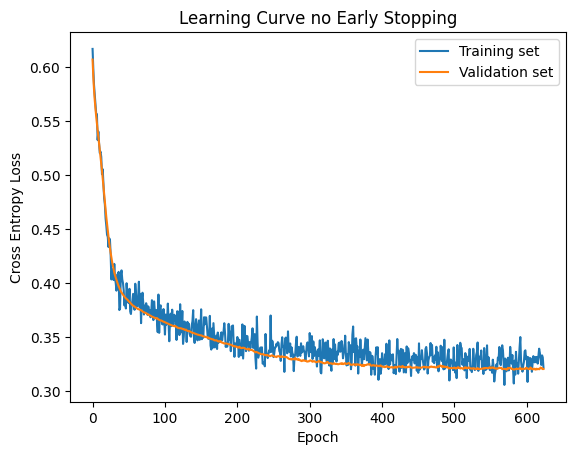

In [89]:
plt.figure()
plt.plot(train_history["epoch"],train_history["loss"], label = "Training set")
plt.plot(val_history["epoch"],val_history["loss"], label = "Validation set")
plt.title("Learning Curve no Early Stopping")
plt.ylabel("Cross Entropy Loss")
plt.xlabel("Epoch")
plt.legend()

In [90]:
predictions = model(test_tensor_dataset.tensors[0]).detach().numpy()
predictions = (predictions>0.5)*1
accuracy = accuracy_score(y_true=test_tensor_dataset.tensors[1].detach().numpy(), y_pred=predictions)

In [91]:
accuracy

0.8475782537067545

In [92]:
print("Accuracy_score:", accuracy)

Accuracy_score: 0.8475782537067545


# B. Evaluate Fairness

### B1.  Demographic Parity

**Demographic parity** , also referred to as **statistical parity** , **acceptance rate parity**  and **benchmarking**

Demographic Parity states that the positive outcome rates between sensitive group must be the same.

---------------
> **Definition Demographic Parity :** We say that a predictor $\hat{Y}$ satisfy **demographic parity** if the predictions $\hat{Y}$ are independent of the sensitive atribute $S$, $\hat{Y} \perp S$.
$$ P_r(\hat{Y}= 1 | S = s ) =  P_r(\hat{Y} = 1), \quad  \forall s\in S $$

in case of 2 sensitive classes, $ s \in \{0,1\}  $ we mesure the bias of model as follows:
$$DP = \; \mid P_r(\hat{Y}= 1 | S = 0 ) -  P_r(\hat{Y}= 1 | S = 1 ) \mid $$  
---------------

In [93]:
def demographic_parity_difference(predictions, sensitive_attribute):
    """
    Implementation of demographic parity difference for different groups of sensitive attribute
    1. For each group calculate the propotion of accepted rate.
    2. Find the maximum and the minim group.
    3. Calcaulte the difference.
    """
    # 1. For each group calculate the proportion of positive predictions.
    # group 0 
    group0_mask = sensitive_atribute == 0
    predictions_group0 = predictions[group0_mask]
    labels_group0 = test_data.loc[group0_mask, target_column]

    positive_rate_group0 = np.sum(predictions_group0 == 1)*1/ predictions_group0.shape[0]

    # group 1 
    group1_mask = sensitive_atribute == 1
    predictions_group1 = predictions[group1_mask]
    labels_group0 = test_data.loc[group1_mask, target_column]

    positive_rate_group1 = np.sum(predictions_group1 == 1)*1 / predictions_group1.shape[0]
    
    # 3. Calculate the different.
    difference = np.abs(positive_rate_group0-positive_rate_group1)
    
    return difference, [positive_rate_group0, positive_rate_group1]

## B2. Equalized Opportunities

**Equalized Opportunities** , also referred to as **true positive parity**, **sensitivity**.

Equalized Opportunities states that each group has equal true positive rates.

---------------
> **Definition Equalized Opportunities :** We say that a predictor $\hat{Y}$ satisfy **equalized opportunities** if the predictions $\hat{Y}$ are independent of the sensitive atribute $S$, conditioned on the positive actual outcome \( Y = 1 \), $\hat{Y} \perp S \mid Y = 1$.
$$ P_r(\hat{Y} = 1 | S = s, Y = 1) = P_r(\hat{Y} = 1 | Y = 1), \quad \forall s \in S $$

in case of 2 sensitive classes, $ s \in \{0,1\}  $ we mesure the bias of model as follows:
$$EO = \; \mid P_r(\hat{Y} = 1 | S = 0, Y = 1) -  P_r(\hat{Y} = 1 | S = 1, Y = 1) \mid $$  
---------------

In [94]:
def equalized_opportunities_difference(predictions, actual, sensitive_attribute):
    """
    Implementation of equalized opportunities difference for different groups of sensitive attribute
    1. For each group calculate the TPR.
    2. Find the maximum and the minim group.
    3. Calculate the difference.
    """
    # 1. For each group calculate the proportion of positive predictions.
    # group 0 
    true_positive_mask = test_data[target_column]==1
    group0_mask = sensitive_atribute == 0
    predictions_group0 = predictions[np.logical_and(group0_mask, true_positive_mask)]

    true_positive_rate_group0 = np.sum(predictions_group0 == 1)*1/ predictions_group0.shape[0]

    # group 1 
    group1_mask = sensitive_atribute == 1
    predictions_group1 = predictions[np.logical_and(group1_mask, true_positive_mask)]
    labels_group0 = test_data.loc[group1_mask, target_column]

    true_positive_rate_group1 = np.sum(predictions_group1 == 1)*1 / predictions_group1.shape[0]
    
    # 3. Calculate the different.
    difference = np.abs(true_positive_rate_group0-true_positive_rate_group1)
    
    return difference, [true_positive_rate_group0, true_positive_rate_group1]

## B3. Equalized Odds

**Equalized Odds** , also referred to as

Equalized Odds states that the true positive rates (TPR) and false positive rates (FPR) between sensitive group must be the same.

---------------
> **Definition Equalized Odds :** A classifier $C$ We say that a predictor $\hat{Y}$ satisfy **equalized Odds** if the predictions $\hat{Y}$ are independent of the sensitive atribute $S$, conditioned on the actual outcome \( Y \), $\hat{Y} \perp S \mid Y$.
$$ P_r(\hat{Y} = 1 | S = s, Y = y) = P_r(\hat{Y} = 1 | Y = y), \quad \forall s \in S \quad \forall y \in Y$$

in case of 2 sensitive classes, $ s \in \{0,1\}  $ we want to satisfy both:
$$ P_c(\hat{Y}= 1 | S = 0, Y = 1 ) =  P_c(\hat{Y}= 1 | S = 1, Y = 1 ) $$ 
and 
$$ P_c(\hat{Y}= 1 | S = 0, Y = 0 ) =  P_c(\hat{Y}= 1 | S = 1, Y = 0 ) $$  
---------------
we mesure the bias of model as follows:
$$EOds = \; \mid P_r(\hat{Y} = 1 | S = 0, Y = 1) -  P_r(\hat{Y} = 1 | S = 1, Y = 1) \mid + \mid P_r(\hat{Y} = 1 | S = 0, Y = 0) -  P_r(\hat{Y} = 1 | S = 1, Y = 0) \mid  $$  

In [95]:
def equalized_odds_difference(predictions, data, sensitive_attribute):
    """
    Implementation of equalized odds difference for different groups of sensitive attribute
    1. For each group calculate the TPR.
    2. Find the maximum and the minim group.
    3. Calcaulte the difference.
    """
    # A. For each group calculate the true positive rate.
    # group 0 
    true_positive_mask = data[target_column]==1
    group0_mask = sensitive_atribute == 0
    predictions_group0 = predictions[np.logical_and(group0_mask, true_positive_mask)]
    labels_group0 = data.loc[group0_mask, target_column]

    true_positive_rate_group0 = np.sum(predictions_group0 == 1)*1/ predictions_group0.shape[0]

    # group 1 
    group1_mask = sensitive_atribute == 1
    predictions_group1 = predictions[np.logical_and(group1_mask, true_positive_mask)]
    labels_group0 = data.loc[group1_mask, target_column]

    true_positive_rate_group1 = np.sum(predictions_group1 == 1)*1 / predictions_group1.shape[0]
    
    # Calculate the different.
    difference1 = np.abs(true_positive_rate_group0-true_positive_rate_group1)
    
    # B. For each group calculate the false positive rate.
    # group 0 
    true_positive_mask = data[target_column]==0
    group0_mask = sensitive_atribute == 0
    predictions_group0 = predictions[np.logical_and(group0_mask, true_positive_mask)]
    labels_group0 = data.loc[group0_mask, target_column]

    false_positive_rate_group0 = np.sum(predictions_group0 == 1)/ predictions_group0.shape[0]

    # group 1 
    group1_mask = sensitive_atribute == 1
    predictions_group1 = predictions[np.logical_and(group1_mask, true_positive_mask)]
    labels_group0 = data.loc[group1_mask, target_column]

    false_positive_rate_group1 = np.sum(predictions_group1 == 1) / predictions_group1.shape[0]
    
    # Calculate the different.
    difference2 = np.abs(false_positive_rate_group0-false_positive_rate_group1)
    
    # Total difference
    difference = difference1 + difference2
    return difference, ([true_positive_rate_group0,true_positive_rate_group1], [false_positive_rate_group0,false_positive_rate_group1])

Wrap the evaluation in a single function

In [96]:
def compute_metric(y_pred, data, sensitive_feature):
    # get all metrics
    acc_score = accuracy_score(y_true=data[target_column], y_pred=y_pred)
    
    demographic_metric, _ = demographic_parity_difference(y_pred,
                                                          sensitive_feature)
    
    equalized_opportunities_metric, _ = equalized_opportunities_difference(y_pred,
                                                                           data,
                                                                          sensitive_feature)
    equalized_odds_metrics, _ = equalized_odds_difference(y_pred,
                                                          data,
                                                          sensitive_feature)
    
    return {
            "accuracy": acc_score,
            "demographic_metric": demographic_metric,
            "equalized_opportunities" : equalized_opportunities_metric,
            "equalized_odds": equalized_odds_metrics
            }

In [97]:
predictions = model(test_tensor_dataset.tensors[0]).detach().numpy()
predictions = (predictions>0.5)*1

In [98]:
sensitive_atribute = test_data[sensitive_feature]

In [99]:
metrics = compute_metric(y_pred = predictions,
                         data = test_data,
                         sensitive_feature = sensitive_atribute)
results = pd.DataFrame(metrics,
                       index = ["simple model"]).T

In [100]:
results

,simple model
accuracy,0.847578
demographic_metric,0.167036
equalized_opportunities,0.106897
equalized_odds,0.179301


<AxesSubplot: >

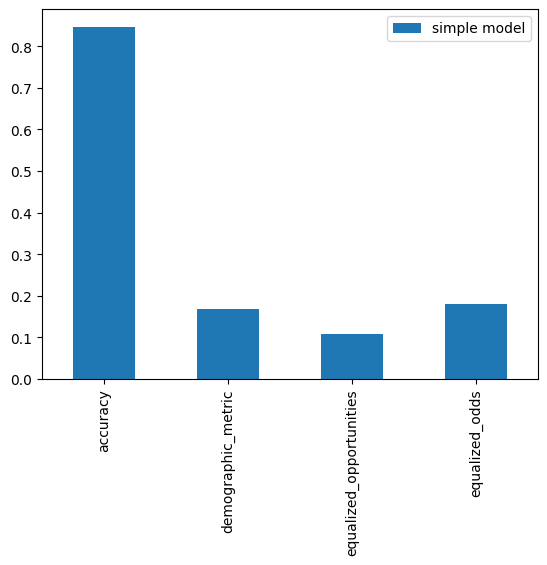

In [102]:
results.plot(kind="bar")

# C. Correct the Unfair Classifier

Numerous recent papers have proposed mechanisms to enhance fairness in machine learning algorithms.

In summary, there are three general methods to correct an unfair classifier:

1. **Pre-Processing**: Make changes to the data before training the model, e.g., removing correlated features.
2. **In-Processing**: Make changes to the model to correct fairness, e.g., adding additional loss terms to ensure fairness.
3. **Post-Processing**: Make changes after the model's output, e.g., adjusting classification thresholds.

For an overview of different methods and fairness criteria, we refer you to the following interesting survey: [https://arxiv.org/pdf/2001.09784.pdf](https://arxiv.org/pdf/2001.09784.pdf).

<div>
<img style="float: left;" src="./figures/corect_unfairness.png" width="400"/>
</div>

# Fair Regularization in Neural Networks

In-processing techniques apply **constraints** or **regularization** during model optimization to enhance fairness.

We will explore a regularization technique that imposes an additional term in the loss function to account for the model’s fairness.

The total loss function is defined as follows:

$$ L = L_{\text{perf}} + \lambda_{1} ||w||^2 + \lambda_{fair}  L_{\text{fair}} $$

Where:
- $ L_{\text{perf}}$ : A loss term that evaluates the model's performance, such as binary cross-entropy.
- $ ||w||^2 $ : A penalty term, L2 regularization, to prevent overfitting by constraining model complexity.
- $ L_{\text{fair}}$ : A penalty term to reduce the model’s bias. This term is adapted to the specific fairness criterion we aim to impose, such as Demographic Parity, Equal Opportunity, or Equalized Odds.

The parameter $\lambda_fair$ controls the strength of the fairness constraint, balancing model accuracy with fairness objectives.


## Optimise Propability Distributions

In fairness-aware machine learning, we impose regularization on model probabilities rather than the final output to  control and adjust the model's decision-making process. By focusing on probabilities, we can introduce a continuous, differentiable measure of fairness that is directly aligned with how the model assigns confidence to its predictions. 

### Demographic Parity

Demographic Parity requires that the predicted probabilities are the same across different groups defined by a sensitive attribute, such as gender or race. Formally, for a sensitive attribute \( A \) (e.g., gender), Demographic Parity can be defined as:

$$
DP = \left| \mathbb{E}_{x \sim P(x | s=0)}[p(\hat{y} = 1 | x)] - \mathbb{E}_{x \sim P(x | s=1)}[p(\hat{y} = 1 | x)] \right|
$$

Where:
- $ s $ denotes the sensitive attribute (e.g., race, gender).
- $ P(x | s=0) $ and $ P(x | s=1)$ are the distributions of the input features $x$ conditioned on the sensitive attribute $s = 0$ and $s = 1$, respectively.
-$ p(\hat{y} = 1 | x)$ is the predicted probability for the outcome $\hat{y} = 1$, given input $x$, form our model.


This means the expected probability of predicting $y = 1$ should be the same for all groups $a$ and $b$ of the sensitive attribute $A$. By regularizing the probabilities, we directly control this balance during training, ensuring that the model does not favor one group over another in terms of predicted outcomes. 

By applying this fairness constraint to the probabilities, rather than the final binary output $\hat{y}$, we ensure that fairness is maintained throughout the model’s decision process, leading to more equitable predictions across different demographic groups.


In [104]:
def training_step(model, input_data, optimizer, loss_fn, lamba):
    # reset gradients of the optimizer
    optimizer.zero_grad()
    
    # unfold data
    (x_batch_g0, y_batch_g0),(x_batch_g1, y_batch_g1) = input_data
    
    # get predictions
    y_pred_propa_g0 = model.forward(x_batch_g0)
    y_pred_propa_g1 = model.forward(x_batch_g1)

    # calculate loss
    loss_g0 = loss_fn(y_pred_propa_g0, y_batch_g0)
    loss_g1 = loss_fn(y_pred_propa_g1, y_batch_g1)
    total_loss = (loss_g0 + loss_g1)/2
    
    # regularization
    regularization = torch.abs(torch.mean(y_pred_propa_g0) - torch.mean(y_pred_propa_g1))
    
    # total loss
    loss = total_loss + lamba * regularization
    
    # compute gradients 
    loss.backward()
    
    # optimise network
    optimizer.step()
    
    # compute metrics for monitoring
    with torch.no_grad(): 
        y_pred_propa = torch.concat([y_pred_propa_g0, y_pred_propa_g1])
        y_true = torch.concat([y_batch_g0, y_batch_g1])
        y_pred = (y_pred_propa>0.5) * 1
        train_acc = torch.sum(y_pred == y_true) / y_pred.shape[0]

    return loss.data.numpy(), train_acc

In [105]:
def evaluation_step(model, input_data, loss_fn, lamba):
    # when we use torch.no_grad pytorch didnt store information
    # that is required to calculate gradients so is fasterr 
    with torch.no_grad(): 
        data_g0, data_g1= input_data
        (x_batch_g0, y_batch_g0) = data_g0.tensors
        (x_batch_g1, y_batch_g1) = data_g1.tensors
        y_pred_propa_g0 = model.forward(x_batch_g0)
        y_pred_propa_g1 = model.forward(x_batch_g1)
        
        # calculate loss
        loss_g0 = loss_fn(y_pred_propa_g0, y_batch_g0)
        loss_g1 = loss_fn(y_pred_propa_g1, y_batch_g1)
        total_loss = (loss_g0 + loss_g1)/2
    
        # regularization
        regularization = torch.abs(torch.mean(y_pred_propa_g0) - torch.mean(y_pred_propa_g1))
    
        # total loss
        loss = total_loss + lamba * regularization

        # compute metrics
        y_pred_propa = torch.concat([y_pred_propa_g0, y_pred_propa_g1])
        y_true = torch.concat([y_batch_g0, y_batch_g1])
        y_pred = (y_pred_propa>0.5) * 1
        acc = torch.sum(y_pred == y_true) / y_pred.shape[0]
        
    return loss.data.numpy(), acc.data.numpy()

In [106]:
# -------------------- Train  Loop----------------------------
def train_loop(train_dataloaders, val_tensor_dataset, patient, epochs, model, optimizer, loss_fn, lamba, steps_per_epoch = 1000):
    best_loss = np.inf
    consecutive_epoch = 0
    best_epoch = 0

    train_history = []
    val_history = []
    for epoch in range(epochs): # iterate over epoch    
        
        # -------------------- Training on each epoch ----------------------------
        accumulated_loss = 0 # monitor loss during training
        accumulated_accuracy = 0 # monitor  accuracy during training
        accuracy_list = []
        for step in range(steps_per_epoch):
            batch_data = []
            d = map(iter,train_dataloaders)
            for data in d:
                batch_data += [next(data)]
            loss, accuracy = training_step(model,batch_data,optimizer,loss_fn,lamba) # train model using a single batch
            accuracy_list += [accuracy]
            accumulated_loss = (step * accumulated_loss + loss)/(step+1)
            accumulated_accuracy =  (step * accumulated_accuracy + accuracy)/(step+1)

        train_history += [{"loss":accumulated_loss, "accuracy":accumulated_accuracy, "epoch": epoch, "set":"train"}]

        # -------------------- Monitor Error Validation set ----------------------------
        val_loss, val_accuracy = evaluation_step(model, val_tensor_dataset, loss_fn, lamba)
        val_history += [{"loss":val_loss, "accuracy":val_accuracy, "epoch": epoch, "set":"val"}]
        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs}:  loss:{accumulated_loss:.3f}, accuracy-:{accumulated_accuracy:.3f}, val_loss:{val_loss:.3f}, val_accuracy->{val_accuracy:.3f}")

        # -------------------- Early Stoping ----------------------------
        if val_loss > best_loss:
            consecutive_epoch += 1
        else:
            best_loss = val_loss # we have an improvement
            consecutive_epoch = 0 # reset counter
            best_epoch = epoch
            best_weights = model.state_dict()

        if consecutive_epoch > patient:
            model.load_state_dict(best_weights) # set best weights
            break
    val_history_df = pd.DataFrame(val_history)
    train_history_df = pd.DataFrame(train_history)
    return model, val_history_df, train_history_df, best_loss, best_epoch, best_weights

### Create the dataset

In [107]:
mask_group_0 = X_train[sensitive_feature] == 0
mask_group_1 = np.logical_not(mask_group_0)

In [108]:
x_train_g0 = X_train_scaled[features].loc[mask_group_0.values]
y_train_g0 = y_train[[target_column]].loc[mask_group_0.values]
train_x_tensor_g0 = torch.tensor(x_train_g0.values, dtype=torch.float)
train_y_tensor_g0 = torch.tensor(y_train_g0[[target_column]].values, dtype=torch.float)
train_dataset_g0 = torch.utils.data.TensorDataset(train_x_tensor_g0, train_y_tensor_g0)
train_dataloader_g0 = torch.utils.data.DataLoader(train_dataset_g0, batch_size=32,shuffle=True)

x_train_g1 = X_train_scaled[features].loc[mask_group_1.values]
y_train_g1 = y_train[[target_column]].loc[mask_group_1.values]
train_x_tensor_g1 = torch.tensor(x_train_g1.values, dtype=torch.float)
train_y_tensor_g1 = torch.tensor(y_train_g1[[target_column]].values, dtype=torch.float)
train_dataset_g1 = torch.utils.data.TensorDataset(train_x_tensor_g1, train_y_tensor_g1)
train_dataloader_g1 = torch.utils.data.DataLoader(train_dataset_g1, batch_size=32,shuffle=True)

In [109]:
mask_group_0 = X_val[sensitive_feature] == 0
mask_group_1 = np.logical_not(mask_group_0)

x_val_g0 = X_val_scaled[features].loc[mask_group_0.values]
y_val_g0 = y_val[[target_column]].loc[mask_group_0.values]
val_x_tensor_g0 = torch.tensor(x_val_g0.values, dtype=torch.float)
val_y_tensor_g0 = torch.tensor(y_val_g0[[target_column]].values, dtype=torch.float)
val_dataset_g0 = torch.utils.data.TensorDataset(val_x_tensor_g0, val_y_tensor_g0)

x_val_g1 = X_val_scaled[features].loc[mask_group_1.values]
y_val_g1 = y_val[[target_column]].loc[mask_group_1.values]
val_x_tensor_g1 = torch.tensor(x_val_g1.values, dtype=torch.float)
val_y_tensor_g1 = torch.tensor(y_val_g1[[target_column]].values, dtype=torch.float)
val_dataset_g1 = torch.utils.data.TensorDataset(val_x_tensor_g1, val_y_tensor_g1)

val_dataset = [val_dataset_g0,val_dataset_g1]

In [110]:
model = NeuralNetwork(num_input_features=12)

lr = 0.005
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.00)
loss_fn = torch.nn.BCELoss() # binary cross entropy

results_training = train_loop(train_dataloaders = (train_dataloader_g0, train_dataloader_g1),
                     val_tensor_dataset= val_dataset,
                     patient = 50,
                     epochs=2000,
                     model=model,
                     optimizer=optimizer,
                     loss_fn=loss_fn,
                     lamba = 2.5,
                     steps_per_epoch=100)
model, val_history, train_history, best_loss, best_epoch, best_weights = results_training    
best_loss

Epoch 0/2000:  loss:0.643, accuracy-:0.784, val_loss:0.624, val_accuracy->0.756
Epoch 10/2000:  loss:0.523, accuracy-:0.791, val_loss:0.520, val_accuracy->0.756
Epoch 20/2000:  loss:0.512, accuracy-:0.787, val_loss:0.503, val_accuracy->0.756
Epoch 30/2000:  loss:0.490, accuracy-:0.797, val_loss:0.491, val_accuracy->0.756
Epoch 40/2000:  loss:0.502, accuracy-:0.783, val_loss:0.480, val_accuracy->0.756
Epoch 50/2000:  loss:0.489, accuracy-:0.792, val_loss:0.467, val_accuracy->0.756
Epoch 60/2000:  loss:0.470, accuracy-:0.802, val_loss:0.455, val_accuracy->0.757
Epoch 70/2000:  loss:0.480, accuracy-:0.793, val_loss:0.438, val_accuracy->0.759
Epoch 80/2000:  loss:0.479, accuracy-:0.795, val_loss:0.431, val_accuracy->0.760
Epoch 90/2000:  loss:0.475, accuracy-:0.796, val_loss:0.434, val_accuracy->0.765
Epoch 100/2000:  loss:0.460, accuracy-:0.808, val_loss:0.437, val_accuracy->0.767
Epoch 110/2000:  loss:0.476, accuracy-:0.801, val_loss:0.415, val_accuracy->0.767
Epoch 120/2000:  loss:0.478

array(0.37091818, dtype=float32)

In [111]:
predictions = model(test_tensor_dataset.tensors[0]).detach().numpy()
predictions = (predictions>0.5)*1

In [112]:
sensitive_atribute = test_data[sensitive_feature]
metrics = compute_metric(y_pred = predictions,
                         data = test_data,
                         sensitive_feature = sensitive_atribute)
results2 = pd.DataFrame(metrics,
                       index = ["Reg DP model"]).T

In [113]:
all_results = pd.concat([results, results2],axis=1)
all_results

,simple model,Reg DP model
accuracy,0.847578,0.788666
demographic_metric,0.167036,0.044799
equalized_opportunities,0.106897,0.376331
equalized_odds,0.179301,0.393115


<AxesSubplot: >

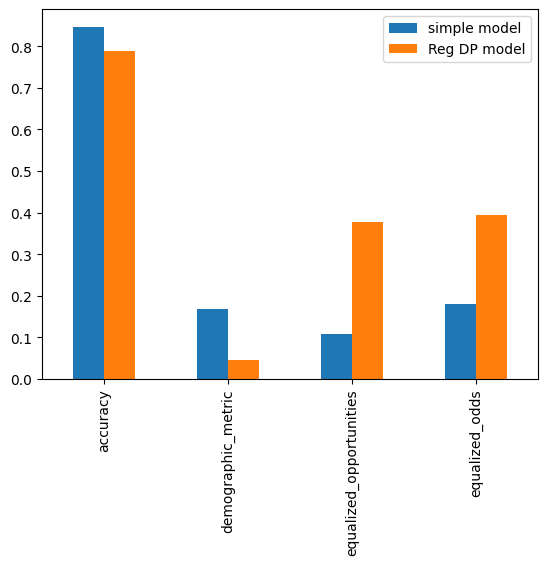

In [114]:
all_results.plot(kind="bar")

## F3. Equalized Opportunities

Similarly, we can regularize the model to preserve Equalized Opportunities. Equalized Opportunities requires that the model has equal true positive rates (TPR) across different sensitive groups, meaning that the probability of a correct positive prediction (i.e., $ \hat{y} = 1 $) given the true label $ y = 1 $ should be the same for all sensitive groups.

The Equalized Opportunities difference (EO) can be defined as:

$$ \text{EO} = \left| \mathbb{E}_{x \sim P(x | y = 1, s = 0)}[p(\hat{y} = 1 | x)] - \mathbb{E}_{x \sim P(x | y = 1, s = 1)}[p(\hat{y} = 1 | x)] \right| $$

Where:
- $ p(\hat{y} = 1 | x) $ is the predicted probability of $ y = 1 $ given input $ x $,
- $ y = 1 $ denotes the positive class,
- $ s $ denotes the sensitive attribute (e.g., gender, race),
- The expectations are taken over the input data conditioned on $ y = 1 $ and the sensitive attribute $ s $.

By regularizing the model according to this criterion, we ensure that the model maintains equal true positive rates across the sensitive groups, thus promoting fairness in the model's predictions.


In [116]:
mask_g0 = X_train[sensitive_feature] == 0
mask_g1 = np.logical_not(mask_g0)

mask_y0 = y_train[target_column] == 0
mask_y1 = np.logical_not(mask_y0)

In [117]:
mask_g0y0 = np.logical_and(mask_g0, mask_y0)
x_train_g0y0 = X_train_scaled[features].loc[mask_g0y0]
y_train_g0y0 = y_train[[target_column]].loc[mask_g0y0]
train_x_tensor_g0y0 = torch.tensor(x_train_g0y0.values, dtype=torch.float)
train_y_tensor_g0y0 = torch.tensor(y_train_g0y0[[target_column]].values, dtype=torch.float)
train_dataset_g0y0 = torch.utils.data.TensorDataset(train_x_tensor_g0y0, train_y_tensor_g0y0)
train_dataloader_g0y0 = torch.utils.data.DataLoader(train_dataset_g0y0, batch_size=32,shuffle=True)

mask_g0y1 = np.logical_and(mask_g0, mask_y1)
x_train_g0y1 = X_train_scaled[features].loc[mask_g0y1]
y_train_g0y1 = y_train[[target_column]].loc[mask_g0y1]
train_x_tensor_g0y1 = torch.tensor(x_train_g0y1.values, dtype=torch.float)
train_y_tensor_g0y1 = torch.tensor(y_train_g0y1[[target_column]].values, dtype=torch.float)
train_dataset_g0y1 = torch.utils.data.TensorDataset(train_x_tensor_g0y1, train_y_tensor_g0y1)
train_dataloader_g0y1 = torch.utils.data.DataLoader(train_dataset_g0y1, batch_size=32,shuffle=True)

mask_g1y0 = np.logical_and(mask_g1, mask_y0)
x_train_g1y0 = X_train_scaled[features].loc[mask_g1y0]
y_train_g1y0 = y_train[[target_column]].loc[mask_g1y0]
train_x_tensor_g1y0 = torch.tensor(x_train_g1y0.values, dtype=torch.float)
train_y_tensor_g1y0 = torch.tensor(y_train_g1y0[[target_column]].values, dtype=torch.float)
train_dataset_g1y0 = torch.utils.data.TensorDataset(train_x_tensor_g1y0, train_y_tensor_g1y0)
train_dataloader_g1y0 = torch.utils.data.DataLoader(train_dataset_g1y0, batch_size=32,shuffle=True)

mask_g1y1 = np.logical_and(mask_g1, mask_y1)
x_train_g1y1 = X_train_scaled[features].loc[mask_g1y1]
y_train_g1y1 = y_train[[target_column]].loc[mask_g1y1]
train_x_tensor_g1y1 = torch.tensor(x_train_g1y1.values, dtype=torch.float)
train_y_tensor_g1y1 = torch.tensor(y_train_g1y1[[target_column]].values, dtype=torch.float)
train_dataset_g1y1 = torch.utils.data.TensorDataset(train_x_tensor_g1y1, train_y_tensor_g1y1)
train_dataloader_g1y1 = torch.utils.data.DataLoader(train_dataset_g1y1, batch_size=32,shuffle=True)

In [118]:
mask_g0 = X_val[sensitive_feature] == 0
mask_g1 = np.logical_not(mask_g0)

mask_y0 = y_val[target_column] == 0
mask_y1 = np.logical_not(mask_y0)

In [119]:
mask_g0y0 = np.logical_and(mask_g0, mask_y0)
x_val_g0y0 = X_val_scaled[features].loc[mask_g0y0]
y_val_g0y0 = y_val[[target_column]].loc[mask_g0y0]
val_x_tensor_g0y0 = torch.tensor(x_val_g0y0.values, dtype=torch.float)
val_y_tensor_g0y0 = torch.tensor(y_val_g0y0[[target_column]].values, dtype=torch.float)
val_dataset_g0y0 = torch.utils.data.TensorDataset(val_x_tensor_g0y0, val_y_tensor_g0y0)

mask_g0y1 = np.logical_and(mask_g0, mask_y1)
x_val_g0y1 = X_val_scaled[features].loc[mask_g0y1]
y_val_g0y1 = y_val[[target_column]].loc[mask_g0y1]
val_x_tensor_g0y1 = torch.tensor(x_val_g0y1.values, dtype=torch.float)
val_y_tensor_g0y1 = torch.tensor(y_val_g0y1[[target_column]].values, dtype=torch.float)
val_dataset_g0y1 = torch.utils.data.TensorDataset(val_x_tensor_g0y1, val_y_tensor_g0y1)

mask_g1y0 = np.logical_and(mask_g1, mask_y0)
x_val_g1y0 = X_val_scaled[features].loc[mask_g1y0]
y_val_g1y0 = y_val[[target_column]].loc[mask_g1y0]
val_x_tensor_g1y0 = torch.tensor(x_val_g1y0.values, dtype=torch.float)
val_y_tensor_g1y0 = torch.tensor(y_val_g1y0[[target_column]].values, dtype=torch.float)
val_dataset_g1y0 = torch.utils.data.TensorDataset(val_x_tensor_g1y0, val_y_tensor_g1y0)

mask_g1y1 = np.logical_and(mask_g1, mask_y1)
x_val_g1y1 = X_val_scaled[features].loc[mask_g1y1]
y_val_g1y1 = y_val[[target_column]].loc[mask_g1y1]
val_x_tensor_g1y1 = torch.tensor(x_val_g1y1.values, dtype=torch.float)
val_y_tensor_g1y1 = torch.tensor(y_val_g1y1[[target_column]].values, dtype=torch.float)
val_dataset_g1y1 = torch.utils.data.TensorDataset(val_x_tensor_g1y1, val_y_tensor_g1y1)
val_dataset = [val_dataset_g0y0,val_dataset_g0y1,val_dataset_g1y0,val_dataset_g1y1]

In [120]:
def training_step(model, input_data, optimizer, loss_fn, lamba):
    # reset gradients of the optimizer
    optimizer.zero_grad()
    
    # unfold data
    data_g0y0, data_g0y1, data_g1y0, data_g1y1 = input_data
    x_batch_g0y0, y_batch_g0y0 = data_g0y0
    x_batch_g0y1, y_batch_g0y1 = data_g0y1
    x_batch_g1y0, y_batch_g1y0 = data_g1y0
    x_batch_g1y1, y_batch_g1y1 = data_g1y1
    
    # get predictions
    y_pred_propa_g0y0 = model.forward(x_batch_g0y0)
    y_pred_propa_g0y1 = model.forward(x_batch_g0y1)
    y_pred_propa_g1y0 = model.forward(x_batch_g1y0)
    y_pred_propa_g1y1 = model.forward(x_batch_g1y1)

    # calculate loss
    loss_g0y0 = loss_fn(y_pred_propa_g0y0, y_batch_g0y0)
    loss_g0y1 = loss_fn(y_pred_propa_g0y1, y_batch_g0y1)
    loss_g1y0 = loss_fn(y_pred_propa_g1y0, y_batch_g1y0)
    loss_g1y1 = loss_fn(y_pred_propa_g1y1, y_batch_g1y1)
    total_loss = (loss_g0y0 + loss_g0y1 + loss_g1y0 + loss_g1y1)/4
    
    # regularization
    regularization = torch.abs(torch.mean(y_pred_propa_g0y1) - torch.mean(y_pred_propa_g1y1))
    
    # total loss
    loss = total_loss + lamba * regularization
    
    # compute gradients 
    loss.backward()
    
    # optimise network
    optimizer.step()
    
    # compute metrics for monitoring
    with torch.no_grad(): 
        y_pred_propa = torch.concat([y_pred_propa_g0y0, y_pred_propa_g0y1,y_pred_propa_g1y0,y_pred_propa_g1y1])
        y_true = torch.concat([y_batch_g0y0, y_batch_g0y1, y_batch_g1y0, y_batch_g1y1])
        y_pred = (y_pred_propa>0.5) * 1
        train_acc = torch.sum(y_pred == y_true) / y_pred.shape[0]

    return loss.data.numpy(), train_acc

In [121]:
def evaluation_step(model, input_data, loss_fn, lamba):
    # when we use torch.no_grad pytorch didnt store information
    # that is required to calculate gradients so is fasterr 
    with torch.no_grad(): 
        data_g0y0, data_g0y1, data_g1y0, data_g1y1 = input_data
        x_batch_g0y0, y_batch_g0y0 = data_g0y0.tensors
        x_batch_g0y1, y_batch_g0y1 = data_g0y1.tensors
        x_batch_g1y0, y_batch_g1y0 = data_g1y0.tensors
        x_batch_g1y1, y_batch_g1y1 = data_g1y1.tensors

        # get predictions
        y_pred_propa_g0y0 = model(x_batch_g0y0)
        y_pred_propa_g0y1 = model(x_batch_g0y1)
        y_pred_propa_g1y0 = model(x_batch_g1y0)
        y_pred_propa_g1y1 = model(x_batch_g1y1)

        # calculate loss
        loss_g0y0 = loss_fn(y_pred_propa_g0y0, y_batch_g0y0)
        loss_g0y1 = loss_fn(y_pred_propa_g0y1, y_batch_g0y1)
        loss_g1y0 = loss_fn(y_pred_propa_g1y0, y_batch_g1y0)
        loss_g1y1 = loss_fn(y_pred_propa_g1y1, y_batch_g1y1)
        total_loss = (loss_g0y0 + loss_g0y1 + loss_g1y0 + loss_g1y1)/4

        # regularization
        regularization = torch.abs(torch.mean(y_pred_propa_g0y1) - torch.mean(y_pred_propa_g1y1))
        
        loss = total_loss + lamba* regularization

        # compute metrics
        y_pred_propa = torch.concat([y_pred_propa_g0y0, y_pred_propa_g0y1,y_pred_propa_g1y0,y_pred_propa_g1y1])
        y_true = torch.concat([y_batch_g0y0, y_batch_g0y1, y_batch_g1y0, y_batch_g1y1])
        y_pred = (y_pred_propa>0.5) * 1
        acc = torch.sum(y_pred == y_true) / y_pred.shape[0]

        
    return loss.data.numpy(), acc.data.numpy()

In [122]:
model = NeuralNetwork(num_input_features=12)

lr = 0.005
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.00)
loss_fn = torch.nn.BCELoss() # binary cross entropy

results_training = train_loop(train_dataloaders = (train_dataloader_g0y0, train_dataloader_g0y1, train_dataloader_g1y0, train_dataloader_g1y1),
                     val_tensor_dataset= val_dataset,
                     patient = 50,
                     epochs=2000,
                     model=model,
                     optimizer=optimizer,
                     loss_fn=loss_fn,
                     lamba = 2.5,
                     steps_per_epoch=100)
model, val_history, train_history, best_loss, best_epoch, best_weights = results_training    
best_loss

Epoch 0/2000:  loss:0.708, accuracy-:0.412, val_loss:0.701, val_accuracy->0.420
Epoch 10/2000:  loss:0.692, accuracy-:0.636, val_loss:0.690, val_accuracy->0.584
Epoch 20/2000:  loss:0.684, accuracy-:0.717, val_loss:0.682, val_accuracy->0.711
Epoch 30/2000:  loss:0.668, accuracy-:0.731, val_loss:0.655, val_accuracy->0.728
Epoch 40/2000:  loss:0.639, accuracy-:0.746, val_loss:0.621, val_accuracy->0.719
Epoch 50/2000:  loss:0.598, accuracy-:0.750, val_loss:0.559, val_accuracy->0.718
Epoch 60/2000:  loss:0.567, accuracy-:0.754, val_loss:0.507, val_accuracy->0.716
Epoch 70/2000:  loss:0.557, accuracy-:0.760, val_loss:0.522, val_accuracy->0.712
Epoch 80/2000:  loss:0.557, accuracy-:0.765, val_loss:0.496, val_accuracy->0.702
Epoch 90/2000:  loss:0.543, accuracy-:0.765, val_loss:0.523, val_accuracy->0.698
Epoch 100/2000:  loss:0.538, accuracy-:0.777, val_loss:0.522, val_accuracy->0.710
Epoch 110/2000:  loss:0.534, accuracy-:0.785, val_loss:0.509, val_accuracy->0.721
Epoch 120/2000:  loss:0.524

array(0.4071798, dtype=float32)

In [123]:
predictions = model(test_tensor_dataset.tensors[0]).detach().numpy()
predictions = (predictions>0.5)*1

In [124]:
sensitive_atribute = test_data[sensitive_feature]
metrics = compute_metric(y_pred = predictions,
                         data = test_data,
                         sensitive_feature = sensitive_atribute)
results3 = pd.DataFrame(metrics,
                       index = ["Reg EO model"]).T

In [125]:
all_results = pd.concat([all_results, results3],axis=1)
all_results

,simple model,Reg DP model,Reg EO model
accuracy,0.847578,0.788666,0.751433
demographic_metric,0.167036,0.044799,0.287562
equalized_opportunities,0.106897,0.376331,0.076200
equalized_odds,0.179301,0.393115,0.275474


<AxesSubplot: >

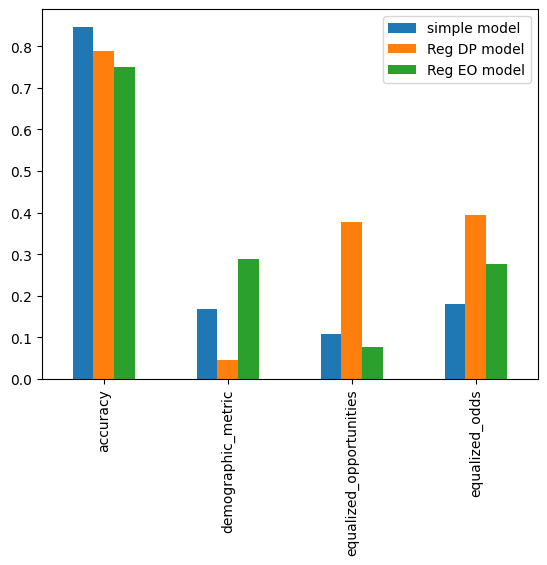

In [126]:
all_results.plot(kind="bar")

## F3. Equalized Odds

Similarly, we can regularize the model to preserve Equalized Odds. Equalized Odds requires that the model has equal true positive rates (TPR) and equal false positive rates (FPR) across different sensitive groups, meaning that the probabilities of both a correct positive prediction and an incorrect positive prediction (i.e., $ \hat{y} = 1 $) given the true label $ y = 1 $ or $ y = 0 $ should be the same for all sensitive groups.

Formally, Equalized Odds can be expressed as:

$$ \mathbb{E}_{x \sim P(x | y = 1, s = 0)}[p(\hat{y} = 1 | x)] = \mathbb{E}_{x \sim P(x | y = 1, s = 1)}[p(\hat{y} = 1 | x)] $$

$$ \mathbb{E}_{x \sim P(x | y = 0, s = 0)}[p(\hat{y} = 1 | x)] = \mathbb{E}_{x \sim P(x | y = 0, s = 1)}[p(\hat{y} = 1 | x)] $$

The Equalized Odds difference (EO) can be defined as:

$$ R1 = \left| \mathbb{E}_{x \sim P(x | y = 1, s = 0)}[p(\hat{y} = 1 | x)] - \mathbb{E}_{x \sim P(x | y = 1, s = 1)}[p(\hat{y} = 1 | x)] \right| $$


$$ R1 =  \left| \mathbb{E}_{x \sim P(x | y = 0, s = 0)}[p(\hat{y} = 1 | x)] - \mathbb{E}_{x \sim P(x | y = 0, s = 1)}[p(\hat{y} = 1 | x)] \right| $$

$$
\text{EO} =  R1 + R2
$$

Where:
- $ p(\hat{y} = 1 | x) $ is the predicted probability of $ y = 1 $ given input $ x $,
- $ y = 1 $ and $ y = 0 $ denote the positive and negative classes, respectively,
- $ s $ denotes the sensitive attribute (e.g., gender, race),
- The expectations are taken over the input data conditioned on the true label $ y $ and the sensitive attribute $ s $.

By regularizing the model according to this criterion, we ensure that the model maintains equal true positive and false positive rates across the sensitive groups, thus promoting fairness in the model's predictions.


In [127]:
def training_step(model, input_data, optimizer, loss_fn, lamba):
    # reset gradients of the optimizer
    optimizer.zero_grad()
    
    # unfold data
    data_g0y0, data_g0y1, data_g1y0, data_g1y1 = input_data
    x_batch_g0y0, y_batch_g0y0 = data_g0y0
    x_batch_g0y1, y_batch_g0y1 = data_g0y1
    x_batch_g1y0, y_batch_g1y0 = data_g1y0
    x_batch_g1y1, y_batch_g1y1 = data_g1y1
    
    # get predictions
   
    # calculate loss
    loss_g0y0 = 
    loss_g0y1 = 
    loss_g1y0 = 
    loss_g1y1 = 
    total_loss = (loss_g0y0 + loss_g0y1 + loss_g1y0 + loss_g1y1)/4
    
    # regularization
    regularization1 =  # R1 True posive rates
    regularization2 =  # R2 False posive rates
    regularization = (regularization1 + regularization2)/2
    
    # total loss
    loss = 
    
    # compute gradients 
    loss.backward()
    
    # optimise network
    optimizer.step()
    
    # compute metrics for monitoring
    with torch.no_grad(): 
        ### accuracy
        train_acc = 

    return loss.data.numpy(), train_acc

In [128]:
def evaluation_step(model, input_data, loss_fn, lamba):
    # when we use torch.no_grad pytorch didnt store information
    # that is required to calculate gradients so is fasterr 
    with torch.no_grad(): 
        data_g0y0, data_g0y1, data_g1y0, data_g1y1 = input_data
        x_batch_g0y0, y_batch_g0y0 = data_g0y0.tensors
        x_batch_g0y1, y_batch_g0y1 = data_g0y1.tensors
        x_batch_g1y0, y_batch_g1y0 = data_g1y0.tensors
        x_batch_g1y1, y_batch_g1y1 = data_g1y1.tensors

        # get predictions
        y_pred_propa_g0y0 =
        y_pred_propa_g0y1 = 
        y_pred_propa_g1y0 = 
        y_pred_propa_g1y1 = 

        # calculate loss
        loss_g0y0 = 
        loss_g0y1 = 
        loss_g1y0 =
        loss_g1y1 = 
        total_loss = (loss_g0y0 + loss_g0y1 + loss_g1y0 + loss_g1y1)/4

        # regularization
        regularization1 = 
        regularization2 = 
        regularization = (regularization1 + regularization2)/2
        
        # total loss
        loss = total_loss + lamba * regularization

        # compute metrics
        acc = 

        
    return loss.data.numpy(), acc.data.numpy()

In [129]:
model = NeuralNetwork(num_input_features=12)

lr = 0.005
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.00)
loss_fn = torch.nn.BCELoss() # binary cross entropy

results_training = train_loop(train_dataloaders = (train_dataloader_g0y0, train_dataloader_g0y1, train_dataloader_g1y0, train_dataloader_g1y1),
                     val_tensor_dataset= val_dataset,
                     patient = 50,
                     epochs=2000,
                     model=model,
                     optimizer=optimizer,
                     loss_fn=loss_fn,
                     lamba = 2.50,
                     steps_per_epoch=100)
model, val_history, train_history, best_loss, best_epoch, best_weights = results_training    
best_loss

Epoch 0/2000:  loss:0.706, accuracy-:0.478, val_loss:0.695, val_accuracy->0.398
Epoch 10/2000:  loss:0.685, accuracy-:0.669, val_loss:0.677, val_accuracy->0.591
Epoch 20/2000:  loss:0.669, accuracy-:0.711, val_loss:0.655, val_accuracy->0.675
Epoch 30/2000:  loss:0.648, accuracy-:0.736, val_loss:0.618, val_accuracy->0.711
Epoch 40/2000:  loss:0.625, accuracy-:0.750, val_loss:0.587, val_accuracy->0.738
Epoch 50/2000:  loss:0.615, accuracy-:0.758, val_loss:0.562, val_accuracy->0.758
Epoch 60/2000:  loss:0.600, accuracy-:0.768, val_loss:0.545, val_accuracy->0.770
Epoch 70/2000:  loss:0.584, accuracy-:0.780, val_loss:0.527, val_accuracy->0.779
Epoch 80/2000:  loss:0.583, accuracy-:0.780, val_loss:0.516, val_accuracy->0.784
Epoch 90/2000:  loss:0.568, accuracy-:0.793, val_loss:0.520, val_accuracy->0.790
Epoch 100/2000:  loss:0.558, accuracy-:0.800, val_loss:0.518, val_accuracy->0.794
Epoch 110/2000:  loss:0.552, accuracy-:0.803, val_loss:0.499, val_accuracy->0.799
Epoch 120/2000:  loss:0.557

array(0.46449196, dtype=float32)

In [130]:
predictions = model(test_tensor_dataset.tensors[0]).detach().numpy()
predictions = (predictions>0.5)*1

In [131]:
sensitive_atribute = test_data[sensitive_feature]
metrics = compute_metric(y_pred = predictions,
                         data = test_data,
                         sensitive_feature = sensitive_atribute)
results3 = pd.DataFrame(metrics,
                       index = ["Reg Eoods model"]).T

In [132]:
all_results = pd.concat([all_results, results3],axis=1)
all_results

,simple model,Reg DP model,Reg EO model,Reg Eoods model
accuracy,0.847578,0.788666,0.751433,0.789918
demographic_metric,0.167036,0.044799,0.287562,0.172120
equalized_opportunities,0.106897,0.376331,0.076200,0.039043
equalized_odds,0.179301,0.393115,0.275474,0.121905


<AxesSubplot: >

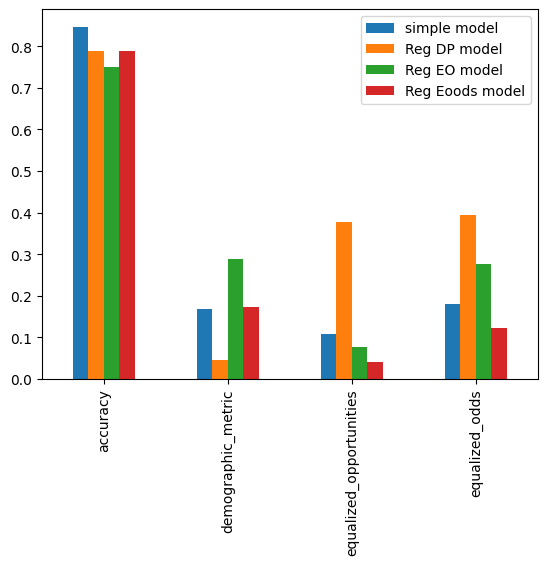

In [133]:
all_results.plot(kind="bar")

# Things to Remember

1. **ML models can be biased due to various sources,** with data-dependent biases being the most common.
2. **Selecting the appropriate fairness criterion** is essential and should align with the specific requirements of our problem.
3. **Fairness metrics can be calculated** using different rates for different groups.
4. **Removing sensitive features does not guarantee fairness** because proxy variables can still introduce bias. In many cases, removing these features does not significantly influence the algorithm.
5. **Biases can be addressed through pre-processing, in-processing, or post-processing methods.**
6. **Different methods involve trade-offs** between fairness and model performance, so choosing the right approach depends on the acceptable balance between these two factors.

For an overview of different methods and fairness critiriaa we refer you to the following survey https://arxiv.org/pdf/2001.09784.pdf.

Fairness python libraries:
https://aif360.readthedocs.io/en/stable/modules/algorithms.html
https://fairlearn.org/